# <p style="text-align: center;">A/B - тестирование механики оплаты услуг на сайте</p> 


## 1. Постановка задачи

Имеется некий сайт, на котором пользователи осуществляют оплату услуг. Существует гипотеза, что изменение механики оплаты позволит увеличить сумму покупок пользователями. Требуется проверить данную гипотезу с помощью A/B-теста. 

**Целевой метрикой является средняя сумма платежа с одного клиента, который произвёл оплату (ARPPU).**


## 2. Исходные данные

Для проведения эксперимента имеются следующие данные: 
* id пользователей;
* группа, к которой отнесён пользователь (А - контрольная, В - экспериментальная); 
* платежи пользователей за время эксперимента. 

Перечисленные данные находятся в нескольких файлах. Кроме того, в течение проведения эксперимента на платформу могут приходить новые пользователи, которым автоматически присваивается та или иная группа. Информация об этих пользователях и присвоенной им группе находится в отдельном файле.  

## 3. Использованные статистические критерии

### Диагностические тесты
Для диагностики применяются следующие тесты: 
* для проверки равенства конверсий между группами - z-тест на разницу пропорций;
* для проверки нормальности - тест Шапиро-Уилка;
* для проверки равенства дисперсий между группами - тест Левена.

### A/B-тест
Для тестирования различий метрик между группами используется t-тест на разницу средних. 
В качестве вспомогательного критерия использован тест Манна-Уитни на сдвиг распределения. 

## 4. Порядок выполнения работы

0. Считывание данных с Яндекс-диска по API


1. Проверяется целостность и корректность данных:
    - всем пользователям должна быть присвоена группа;
    - не должно быть повторяющихся id пользователей в одной и той же таблице;
    - не должно быть пользователей, отсутствующих в таблице с их общим списком. 


2. Составляются сводные таблицы по группам пользователей, рассчитываются групповые метрики, давая базовую информацию о структуре данных.


3. Анализируются распределения стоимостных показателей, в том числе в разрезе групп, выявляются аномалии, если они есть.


4. Сравниваются группы пользователей на основе целевой метрики. 

### Загрузка данных

In [1]:
# загрузка используемых библиотек

import requests
import urllib
import json

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from scipy import stats
import pingouin as pg
from statsmodels.stats.proportion import proportions_ztest

import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
'''
Загрузка требуемых данных. Все данные загружены на Яндекс-диск, поэтому создана функция для их считывания.
'''

source_url = 'https://disk.yandex.ru/d/9dpU6A-8TQ_Ttw'

active_studs_url = 'active_studs.csv'
groups_url = 'groups.csv'
groups_add_url = 'group_add.csv'
checks_url = 'checks.csv'

def create_df_from_url(source_url, file_url, sep = ','):
    yandex_download_api_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download'
    full_url = yandex_download_api_url + \
               '?public_key=' + urllib.parse.quote(source_url) + '&path=/' + urllib.parse.quote(file_url)
    r = requests.get(full_url) # запрос ссылки на скачивание
    h = json.loads(r.text)['href'] # 'парсинг' ссылки на скачивание
    df = pd.read_csv(h, sep, error_bad_lines=False, comment='#')
    return df

# файл с id пользователей, которые зашли на платформу в дни проведения эксперимента
active_studs = create_df_from_url(source_url, active_studs_url)
active_studs.name = 'Active_students'

# файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе 
# (А – контроль, B – целевая группа)
groups = create_df_from_url(source_url, groups_url, sep = ';')

# файл с новыми пользователями, которые зарегистрировались в течение проведения эксперимента
# и принадлежности его к группе
groups_add = create_df_from_url(source_url, groups_add_url, sep = ',')

# файл с информацией о суммах платежей пользователей в дни проведения эксперимента.
checks = create_df_from_url(source_url, checks_url, sep = ';')
checks.name = 'Checks'

In [18]:
# настройки графиков

get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'svg'")
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['image.cmap'] = 'viridis'

# переименовываем переменные id для единообразия
groups = groups.rename(columns={'id':'student_id'})
groups.name = 'Users_by_groups'

groups_add = groups_add.rename(columns={'id':'student_id'})
groups_add.name = 'New_users_by_groups'

# создаём объединённый dataset пользователей и групп
groups_total = pd.concat([groups, groups_add])
groups_total = groups_total.reset_index(drop = True)

In [19]:
# как устроены данные

display(active_studs.head(1))
display(groups.head(1))
display(groups_add.head(1))
display(checks.head(1))

,student_id
0,581585


,student_id,grp
0,1489,B


,student_id,grp
0,5694584,B


,student_id,rev
0,1627,990.0


## Проверка на корректность данных

Алгоритм проверки написан на случай любых данных аналогичной структуры, 
с возможностью масштабирования (ограниченного).

В результате работы алгоритма либо возвращается сообщение о том, что ошибок не обнаружено,
либо возвращается сообщение о том, какая конкретно ошибка и в какой таблице. 

In [20]:
# Проверка на уникальность id
def check_unique_id(df):
    duplicated_ids = df['student_id'][df['student_id'].duplicated()]
    if len(duplicated_ids) == 0:
        check_unique = 1
        return [1, 'Нет повторяющихся id!']
    else:
        return [0, f'{df.name}. Обнаружены повторяющиеся id! Номера: {list(duplicated_ids)}']

# Проверка на наличие пользователей, которым не присвоена группа

def check_missed_values(df):
    if df.all(skipna = False).all() == True:
        check_missed = 1
        return [1, 'Среди пользователей и групп нет пропущенных значений!']
    else:
        return [0, 'Среди пользователей и групп есть пропущенные значения!']

# Проверка на наличие платежей от несуществующих id

def check_pays_not_exist_id(df_checks, df_all_users):
    if set(df_checks['student_id']).issubset(set(df_all_users['student_id'])):
        check_payments = 1
        return [1, 'Пользователи всех платежей идентифицированы!']
    else:
        return [0, 'Существуют платежи от неидентифицированных пользователей!']

# Проверка на посетителей с несуществующими id

def check_active_not_exist_id(df_active_users, df_all_users):
    if set(df_active_users['student_id']).issubset(set(df_all_users['student_id'])):
        check_visitors = 1
        return [1, 'Все активные пользователи зарегистрированы в базе!']
    else:
        return [0, 'Не все активные пользователи зарегистрированы в базе!']

# Помещаем результаты проверки и их расшифровку инфо-сообщениями в словарь

checking = {'check_results': 
            {'check_unique_id':[check_unique_id(active_studs)[0],
                                check_unique_id(groups)[0],
                                check_unique_id(groups_add)[0],
                                check_unique_id(checks)[0]
                               ],
             'check_missed_values':[check_missed_values(groups)[0],check_missed_values(groups_add)[0]],
             'check_pays_not_exist_id':[check_pays_not_exist_id(checks, groups_total)[0]],
             'check_active_not_exist_id':[check_active_not_exist_id(active_studs, groups_total)[0]]
            },
            'check_descriptions':
             {'check_unique_id':[check_unique_id(active_studs)[1],
                                check_unique_id(groups)[1],
                                check_unique_id(groups_add)[1],
                                check_unique_id(checks)[1]
                                ],
             'check_missed_values':[check_missed_values(groups)[1],
                                    check_missed_values(groups_add)[1]
                                   ],
             'check_pays_not_exist_id':[check_pays_not_exist_id(checks, groups_total)[1]],
             'check_active_not_exist_id':[check_active_not_exist_id(active_studs, groups_total)[1]]
             }
           }

# Раскрываем словарь

check_results = [values for sublist in checking['check_results'].values() for values in sublist]
check_descriptions = [values for sublist in checking['check_descriptions'].values() for values in sublist]

# Создаём условие для вывода результата

if pd.Series(check_results).mean() == 1:
    print('Результат проверки положительный: ошибки и пропущенные значения в данных не обнаружены!')
else:
    check_not_passed = [i for i in range(len(check_results)) if check_results[i] != 1]
    print('Результат проверки отрицательный!')
    print([check_descriptions[j] for j in check_not_passed])

Результат проверки положительный: ошибки и пропущенные значения в данных не обнаружены!


## Расчёт первичных данных о группах пользователей

Определим в разрезе каждой группы: 
* количество пользователей всего;
* количество активных пользователей (тех, кто заходил на платформу);
* суммарную выручку и в среднем на одного пользователя;
* суммарную и среднюю выручку по активным пользователям;
* конверсию в покупку. 

In [21]:
# создание таблиц, на основе которых производится расчёт показателей

active_studs = active_studs.merge(groups, on = 'student_id', how = 'inner')
checks = checks.merge(groups, on = 'student_id', how = 'inner')
checks_by_active = checks[checks['student_id'].isin(active_studs['student_id'])]

# создание группировок

count_users = groups.groupby('grp', as_index=False).agg({'student_id':'count'})
count_active_users = active_studs.groupby('grp', as_index=False).agg({'student_id':'count'})

count_paying_users = checks.groupby('grp', as_index=False).agg({'student_id':'count'})
count_paying_active_users = checks_by_active.groupby('grp', as_index=False).agg({'student_id':'count'})

checks_sums = checks.groupby('grp', as_index = False).agg({'rev':'sum'}).round(2)
checks_mean = checks.groupby('grp', as_index = False).agg({'rev':'mean'}).round(2)

checks_active_sums = checks_by_active.groupby('grp', as_index = False).agg({'rev':'sum'}).round(2)
checks_active_mean = checks_by_active.groupby('grp', as_index = False).agg({'rev':'mean'}).round(2)

In [22]:
# функция для удаления дублирующихся колонок
def delete_duplicated_columns(df):
    return df.loc[:,~df.apply(lambda x: x.duplicated(),axis=1).all()].copy()

# создание сводной таблицы с данными о количестве пользователей

user_metrics = pd.concat([count_users, count_active_users, count_paying_users, 
                          count_paying_active_users], axis=1)
user_metrics = delete_duplicated_columns(user_metrics)

user_metrics.columns = ['group', 'count_users', 'count_active_users', 'count_paying_users', 
                         'count_paying_active_users']

user_metrics.loc["Total"] = user_metrics.sum()

# создание сводной таблицы с данными о платежах пользователей

payment_metrics = pd.concat([checks_sums, checks_active_sums, 
                             checks_mean, checks_active_mean], axis=1)
payment_metrics = delete_duplicated_columns(payment_metrics)

payment_metrics.columns = ['group', 'checks_sums', 'checks_active_sums', 'checks_mean', 'checks_active_mean']

payment_metrics_total = \
              ['AB', payment_metrics.checks_sums.sum(), 
               payment_metrics.checks_active_sums.sum(),
               payment_metrics.checks_sums.sum() / user_metrics.count_paying_users.loc['Total'],
               payment_metrics.checks_active_sums.sum() / user_metrics.count_paying_active_users.loc['Total']]

payment_metrics.loc["Total"] = payment_metrics_total
payment_metrics = payment_metrics.round(2)

In [23]:
# результаты по группам пользователей

print('Показатели по количеству пользователей в разрезе групп:')
display(user_metrics)

print('Показатели по суммам платежей и средней выручке в разрезе групп:')
display(payment_metrics)

Показатели по количеству пользователей в разрезе групп:


,group,count_users,count_active_users,count_paying_users,count_paying_active_users
0,A,14671,1535,107,78
1,B,59813,6793,433,313
Total,AB,74484,8328,540,391


Показатели по суммам платежей и средней выручке в разрезе групп:


,group,checks_sums,checks_active_sums,checks_mean,checks_active_mean
0,A,92096.0,72820.0,860.71,933.59
1,B,479330.0,393074.0,1107.00,1255.83
Total,AB,571426.0,465894.0,1058.20,1191.54


### Комментарии по первичным данным

По данным о количестве пользователей можно отметить следующие факты:

**1) Число пользователей, которые платили на платформе во время эксперимента, превышает число тех, которые оплачивали и заходили на платформу в тот же период.**

Отсюда можно сделать вывод, что часть пользователей совершает оплату, не посещая платформу. Вероятнее всего, для этих пользователей оплата проходит по системе подписки, при этом фактически они не пользуются сервисом. Такие пользователи могут внести искажения в результаты эксперимента, поэтому из дальнейших расчётов таких пользователей следует исключить. 

**2) Средняя выручка на одного активного пользователя выше, чем в среднем по всем пользователям по обеим группам.**

Это соответствует интуиции и позволяет предполагать, что активные пользователи платформы платят больше, чем среднестатистические. Суммарная выручка от этой категории пользователей также составляет свыше 3/4 общей выручки за время эксперимента. 

**3) Пользователи неравномерно разбиты между группами "А" и "В".**

Чтобы убедиться, что такое разбиение не будет приводить к искажениям, необходимо сравнить, что соблюдены одинаковые пропорции в распределении между группами "А" и "В" как по всем активным пользователям, так и по той её части, которая производила оплату. 

Далее проведём расчёты для проверки равенства пропорций между группами. 

In [10]:
# создаём dataset, на основе которого будет производиться сравнение пропорций

users_data = pd.DataFrame({'active_users': user_metrics['count_active_users'],
                           'inactive_users': user_metrics['count_users'] - user_metrics['count_active_users'],
                           'active_paying_users': user_metrics['count_paying_active_users'],
                           'inactive_paying_users': user_metrics['count_paying_users'] - user_metrics['count_paying_active_users']})
users_data.index = ['A', 'B', 'Total']

z_pval_active_users = proportions_ztest(users_data.loc['A', 'active_users':'inactive_users'], 
                                        users_data.loc['Total', 'active_users':'inactive_users'])[1].round(4)

z_pval_active_paying_users = proportions_ztest(users_data.loc['A', 'active_paying_users':'inactive_paying_users'], 
                                               users_data.loc['Total', 'active_paying_users':'inactive_paying_users'])[1].round(4)

print('Таблица для сравнения пропорций распределения между группами: ')
display(users_data)

print(f'p-value z-теста на сравнение пропорции группы А среди всех активных пользователей: {z_pval_active_users}')

print(f'p-value z-теста на сравнение пропорции группы А среди активных платных пользователей: {z_pval_active_paying_users}')

Таблица для сравнения пропорций распределения между группами: 


,active_users,inactive_users,active_paying_users,inactive_paying_users
A,1535,13136,78,29
B,6793,53020,313,120
Total,8328,66156,391,149


p-value z-теста на сравнение пропорции группы А среди всех активных пользователей: 0.0021
p-value z-теста на сравнение пропорции группы А среди активных платных пользователей: 0.8993


Между активными и неактивными пользователями неодинаковая пропорция в группе А (p-value близок к нулю, нулевая гипотеза отвергается). При этом доля платных активных и неактивных пользователей в группе А одинакова (p-value ближе к единице, нулевая гипотеза не отвергается). 

За счёт этого эффекта, конверсия между группами "А" и "В" может быть неодинаковой. Проверим соответствующую гипотезу.

In [11]:
# создание сводной таблицы с данными о конверсии по группам

conversion_by_user = (user_metrics.count_paying_active_users / user_metrics.count_active_users).round(4)*100
ARPPU = (payment_metrics.checks_active_sums / user_metrics.count_paying_active_users).round(2)
ARPU = (payment_metrics.checks_active_sums / user_metrics.count_active_users).round(2)
conversion_by_payment = (ARPU / ARPPU).round(4)*100

conversion_table = pd.concat([conversion_by_user, ARPPU, ARPU, conversion_by_payment], axis = 1)
conversion_table.columns = ['CR, %', 'ARPPU', 'ARPU', 'CR_check, %']
conversion_table.index = ['A', 'B', 'Total']

print('Основные метрики по группам: ')
display(conversion_table)

# проверка гипотезы о том, что конверсия в группах одинакова

z_pval_conversion = proportions_ztest(user_metrics.count_paying_active_users[0:2],
                                      user_metrics.count_active_users[0:2])[1].round(4)

print(f'p-value z-теста на сравнение конверсий: {z_pval_conversion}')

Основные метрики по группам: 


,"CR, %",ARPPU,ARPU,"CR_check, %"
A,5.08,933.59,47.44,5.08
B,4.61,1255.83,57.86,4.61
Total,4.70,1191.54,55.94,4.69


p-value z-теста на сравнение конверсий: 0.4281


Нулевая гипотеза о равенстве конверсий между группами "А" и "В" не отвергается. Следовательно, можно предполагать, что разбиение на группы произведено корректно и продолжать анализ. 

## Анализ распределений платежей по группам

Рассмотрим описательные статистики и графики распределений платежей в каждой из групп "А" и "В". 

Описательная статистика по платежам активных пользователей во время эксперимента:


,count,mean,std,min,25%,50%,75%,max
A,78.0,933.59,919.93,199.0,290.0,585.0,1114.75,3660.0
B,313.0,1255.83,791.29,199.0,489.0,1140.0,1900.00,4650.0


Графики распределений:


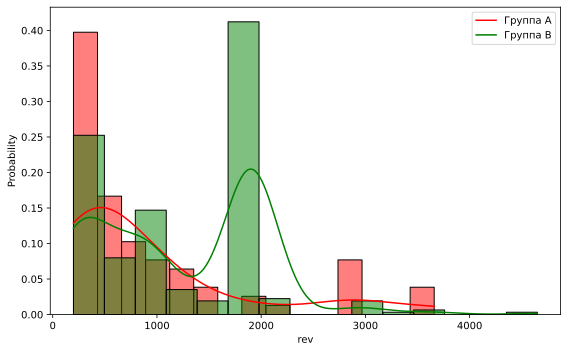

Тест на нормальность распределения по критерию Шапиро-Уилка.
p-value для группы А, с точностью до 5 знаков: 0.0
p-value для группы B, с точностью до 5 знаков: 0.0


In [12]:
# определяем группы платежей и считаем по ним описательную статистику

checks_group_A = checks_by_active[checks_by_active['grp'] == 'A'].rev
checks_group_B = checks_by_active[checks_by_active['grp'] == 'B'].rev
desc_checks_group_A = checks_group_A.describe().round(2)
desc_checks_group_B = checks_group_B.describe().round(2)

desc_stat = pd.DataFrame([desc_checks_group_A, desc_checks_group_B], 
                         index=['A', 'B'])

print('Описательная статистика по платежам активных пользователей во время эксперимента:')
display(desc_stat)

# создаём гистограммы распределений

print('Графики распределений:')
plt.figure(figsize=(8, 5))
sns.histplot(checks_group_A, stat='probability', kde=True, color='red', bins=15)
sns.histplot(checks_group_B, stat='probability', kde=True, color='green', bins=15)
plt.legend(labels=["Группа А","Группа В"])
plt.show()

# тест на нормальность распределения платежей

normality_pval_A = round(float(stats.shapiro(checks_group_A)[1]),5)
normality_pval_B = round(float(stats.shapiro(checks_group_B)[1]),5)

print('Тест на нормальность распределения по критерию Шапиро-Уилка.')
print(f'p-value для группы А, с точностью до 5 знаков: {normality_pval_A}')
print(f'p-value для группы B, с точностью до 5 знаков: {normality_pval_B}')

### Выводы о распределении платежей

В обеих группах - и А, и В - платежи распределены неоднородно, не соответствуют нормальному распределению и значительно варьируются. При этом если в группе А доля пользователей убывает с увеличением суммы платежа, то в группе В наблюдается бимодальность - часть пользователей имеют тот же паттерн платежей, что и в группе А, но у значительной части он сместился по сравнению с группой А. 

Очевидно, что эффект нового экрана оплаты не изменит поведение всех 100% пользователей, поэтому часть пользователей может иметь тот же паттерн поведения, что и в группе А, это наблюдается на графике. 

Рассмотрим, какие значения формируют вторую моду в группе В. 

In [13]:
# проверка сумм платежей

checks_group_B.value_counts(ascending = False).head(10).sort_index(ascending = False)

1900.0001    35
1900.0000    92
1140.0000     9
990.0000     17
840.0000     21
690.0000     13
590.0000      6
398.0000      6
290.0000     45
199.0000     27
Name: rev, dtype: int64

**Вторая мода на графике сформирована высокой частотой значений 1900 и 1900.0001.** Т.к. они отличаются в денежном эквиваленте незначительно, необходимо проверить записи о суммах платежей на предмет наличия ошибки. 
Если допустить, что ошибки нет, то можно продолжить исследование и перейти к сравнению групп. 


## Сравнение групп А и В

In [14]:
# тест на равенство дисперсий в группах
variance_pval = stats.levene(checks_group_A, checks_group_B)[1]

print('Тест Levene на равенство дисперсий платежей в группах. \n')
print(f'p-value: {round(variance_pval,5)}')

# t-тест на равенство средних в группах

diff = checks_group_A.mean() - checks_group_B.mean()
ttest = pg.ttest(checks_group_A, checks_group_B)
ttest_pval = ttest['p-val'][0]

CI_left = pg.ttest(checks_group_A, checks_group_B)['CI95%'][0][0]
CI_right = pg.ttest(checks_group_A, checks_group_B)['CI95%'][0][1]
power = ttest["power"][0]

print('\n--------------------------------------------\n')
print('Тест на равенство среднего размера платежей в группах. \n')
print(f'p-value: {round(ttest_pval, 5)} \n')

print(f'Мощность теста: {round(power,3)}')
print(f'\nДоверительный интервал (95%) разницы средних: [{CI_left} ; {CI_right}]')


if power < 0.95:
    print('\n--------------------------------------------\n')
    cohens_d = float(pg.ttest(checks_group_A, checks_group_B)['cohen-d'])
    power = 0.95
    power_cohens_d = pg.power_ttest2n(checks_group_A.count(), checks_group_B.count(), power = power)
    power_wish_diff = round(power_cohens_d * diff / cohens_d,2)
    print(f'Для получения значимых отличий с надёжностью alpha = 0.05 и '
          f'мощностью power = 0.95 разница между группами \n(при той же дисперсии) должна составить: {power_wish_diff}')


Тест Levene на равенство дисперсий платежей в группах. 

p-value: 0.08124

--------------------------------------------

Тест на равенство среднего размера платежей в группах. 

p-value: 0.00536 

Мощность теста: 0.874

Доверительный интервал (95%) разницы средних: [-546.96 ; -97.52]

--------------------------------------------

Для получения значимых отличий с надёжностью alpha = 0.05 и мощностью power = 0.95 разница между группами 
(при той же дисперсии) должна составить: -374.26


### Интерпретация полученных результатов

p-value показывает вероятность ошибочно отвергнуть нулевую гипотезу, когда она на самом деле верна. Нулевая гипотеза заключается в том, что отличия между группами отсутствуют. Для теста на равенство дисперсий эта вероятность выше уровня значимости 0,05, поэтому делаем вывод, что дисперсии в группах с высокой вероятностью отличаются. 

Поэтому необходимо оценивать разницу средних с поправкой на неравные дисперсии (t-тест Уэлча). Этот тест применяется по умолчанию в используемой библиотеке. Для него p-value близок к нулю, соответственно, вероятность ошибки первого рода крайне мала, следовательно, можно предполагать, что средняя выручка (ARPPU) между группами отличается. 

Мощность - вероятность того, что отличия есть и они выявлены тестом - обратна вероятности ошибки второго рода. Эта вероятность близка к единице и с учётом того, что нулевая гипотеза отвергается - полученные результаты можно считать надёжными. 

# Заключение

Эксперимент показывает статистически значимые отличия между платежами пользователей в группах А и В. В группе В средняя сумма платежа выше. При этом конверсия между группами А и В значимо не отличается. Определим возможный экономический эффект, который мог бы быть получен за время эксперимента в случае распространения новой механики оплаты на всех пользователей. 

In [30]:
'''
Определяем дополнительный объём выручки, который будет получен, если на всех пользователей
из группы А распространить новую механику оплаты и их ARPPU будет соответствовать величине ARPPU в группе В.
'''

delta_ARPPU = round(checks_group_B.mean() - checks_group_A.mean(),2)
delta_percent_ARPPU = round((checks_group_B.mean() / checks_group_A.mean() - 1)*100,2)
rev_actual = round(checks_group_B.mean() * checks_group_B.count() \
                   + checks_group_A.mean() * checks_group_A.count(),2)
rev_B = round(checks_group_B.mean() * (checks_group_A.count() + checks_group_B.count()),2)
delta_rev = round((checks_group_B.mean() - checks_group_A.mean()) * checks_group_A.count(),2)
delta_percent = round((rev_B / rev_actual - 1) * 100,2)

print(f'Средняя выручка с одного активного пользователя увеличилась на: {delta_ARPPU}, прирост: {delta_percent_ARPPU}% \n')
print(f'Если ARPPU сохранится на том же уровне после раскатки на всех пользователей, то дополнительный \n' \
      f'возможный объём выручки  за время эксперимента от новой механики оплаты: {delta_rev} \n')
print(f'Тогда общая выручка за тот же период составила бы: {rev_B}, прирост: {delta_percent}%')

Средняя выручка с одного активного пользователя увеличилась на: 322.24, прирост: 34.52% 

Если ARPPU сохранится на том же уровне после раскатки на всех пользователей, то дополнительный 
возможный объём выручки  за время эксперимента от новой механики оплаты: 25134.54 

Тогда общая выручка за тот же период составила бы: 491028.55, прирост: 5.39%


***Если комментарий о несоответствии в данных и комментарий об ошибках в платежах учтён*** и ошибок сбора данных нет, то можно рекомендовать внедрение исследуемой механики на всех пользователей. 